In [1]:
import rasterio
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
import folium

### Read and Plot Raw LST data

In [2]:
lst = rioxarray.open_rasterio('data/ECOv002_L2T_LSTE_26214_003_32UPU_20230219T061752_0710_01_LST.tif', masked = True)
lst.values

array([[[271.2 , 271.28, 270.58, ..., 262.2 , 262.32, 262.64],
        [270.62, 270.76, 271.9 , ..., 261.9 , 261.9 , 262.24],
        [271.14, 271.2 , 271.7 , ..., 262.48, 262.44, 262.24],
        ...,
        [269.36, 269.3 , 269.3 , ..., 262.7 , 262.86, 264.58],
        [269.94, 269.66, 269.66, ..., 262.68, 263.42, 264.96],
        [269.92, 270.  , 269.54, ..., 262.02, 262.16, 264.66]]],
      dtype=float32)

In [3]:
# Show CRS
lst.rio.crs

CRS.from_epsg(32632)

In [27]:
lst_repr.band

<xarray.DataArray 'band' (band: 1)>
array([1])
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0

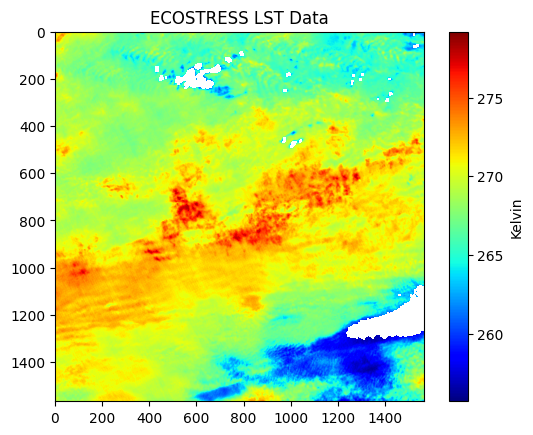

In [4]:
# Plot Raw Heatmap Data
plt.imshow(lst.squeeze().values, cmap='jet')
plt.colorbar(label='Kelvin')
plt.title('ECOSTRESS LST Data')
plt.show()

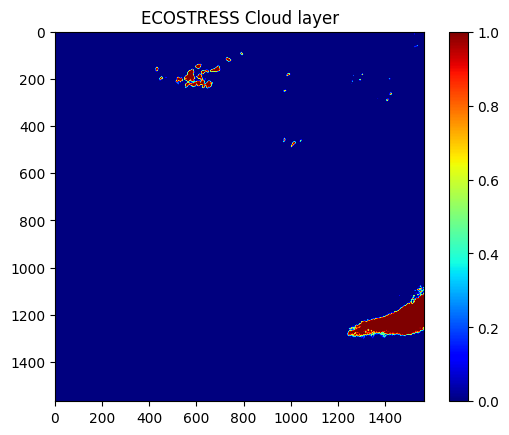

In [5]:
# Check Cloud layer to explain missing values in heatmap
clouds = rioxarray.open_rasterio('data/ECOv002_L2T_LSTE_26214_003_32UPU_20230219T061752_0710_01_cloud.tif', masked = True)
plt.imshow(clouds.squeeze().values, cmap='jet')
plt.colorbar()
plt.title('ECOSTRESS Cloud layer')
plt.show()

In [6]:
# Calculate cloud saturation overall
cloud_val = clouds.squeeze().values
(np.count_nonzero(cloud_val) / cloud_val.size)*100

1.4519910323823408

In [7]:
# Check LST error data
lst_err = rioxarray.open_rasterio('data/ECOv002_L2T_LSTE_26214_003_32UPU_20230219T061752_0710_01_LST_err.tif', masked = True)
lst_err.squeeze().values

array([[1.  , 1.  , 1.  , ..., 1.08, 1.08, 1.08],
       [1.  , 1.  , 1.  , ..., 1.08, 1.08, 1.08],
       [1.  , 1.  , 1.  , ..., 1.08, 1.08, 1.08],
       ...,
       [1.12, 1.12, 1.12, ..., 1.08, 1.08, 1.08],
       [1.12, 1.12, 1.12, ..., 1.08, 1.08, 1.08],
       [1.12, 1.12, 1.12, ..., 1.08, 1.08, 1.08]], dtype=float32)

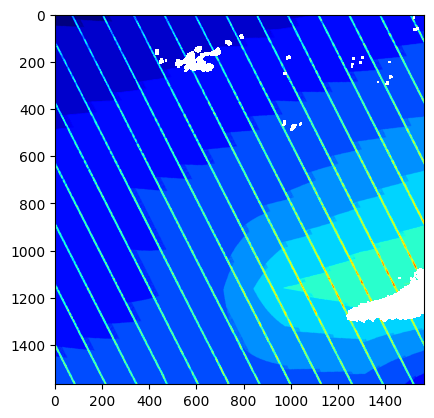

In [8]:
plt.imshow(lst_err.squeeze().values, cmap='jet')

### Reproject data and Plot interactively

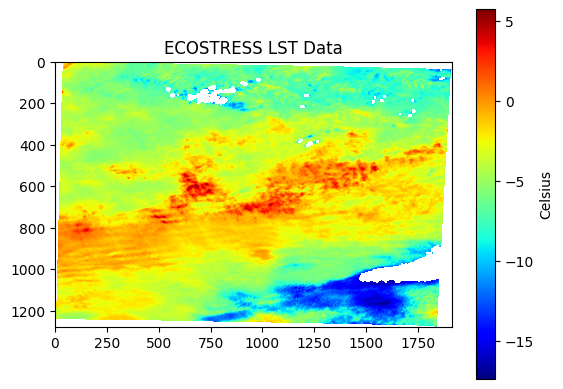

In [9]:
# Reproject to WGS84
lst_repr = lst.rio.reproject('EPSG:4326')
# Convert temperature to Celsius
temp_cels = lst_repr.squeeze().values - 273.15

plt.imshow(temp_cels, cmap='jet')
plt.colorbar(label='Celsius')
plt.title('ECOSTRESS LST Data')
plt.show()

In [12]:
# Extract the data and the transform
temperature_values = lst_repr.values[0]
temperature_values = temperature_values- 273.15
temperature_values[np.isnan(temperature_values)] = 0
temperature_values = temperature_values.astype('float')

transform = lst_repr.rio.transform()

# Convert the temperature data to latitude and longitude coordinates using the rioxarray transform object
ny, nx = temperature_values.shape
lats, lons = [], []
for j in range(ny):
    for i in range(nx):
        lon, lat = transform * (i, j)
        lats.append(lat)
        lons.append(lon)

# Create the heatmap layer using folium.plugins.HeatMap
data = list(zip(lats, lons, temperature_values.flatten()))
data = [list(x) for x in data]

In [ ]:
# Create a folium map centered on the mean of the latitude and longitude coordinates
map_center = [(min(lats) + max(lats)) / 2, (min(lons) + max(lons)) / 2]
m = folium.Map(location=map_center, zoom_start=9)

from folium.plugins import HeatMap
HeatMap(data=data, 
        name='Temperature heatmap',
        min_opacity=0.6,
        radius = 10,
        max_val=temperature_values.max(),
        min_val=temperature_values.min(),
        gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'yellow', 0.8: 'orange', 1: 'red'}).add_to(m)

# Add a layer control to the map
folium.LayerControl().add_to(m)

# Show the folium map
m